In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# importing required libraries
import numpy as np
import pandas as pd
import pickle # saving and loading trained model
from os import path

# importing required libraries for normalizing data
from sklearn import preprocessing
from sklearn.preprocessing import (StandardScaler, OrdinalEncoder,LabelEncoder, MinMaxScaler, OneHotEncoder)
from sklearn.preprocessing import Normalizer, MaxAbsScaler , RobustScaler, PowerTransformer

# importing library for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import accuracy_score # for calculating accuracy of model
from sklearn.model_selection import train_test_split # for splitting the dataset for training and testing
from sklearn.metrics import classification_report # for generating a classification report of model

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout # importing dense layer
from keras.models import Sequential #importing Sequential layer
from keras.layers import Input
from keras.models import Model

In [ ]:
feature=["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot",
          "num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells",
          "num_access_files","num_outbound_cmds","is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate",
          "rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
          "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate",
          "dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty"]

In [ ]:
train='/content/drive/MyDrive/NSL_KDD_dataset/KDDTrain.txt'
test='/content/drive/MyDrive/NSL_KDD_dataset/KDDTest.txt'
train_data=pd.read_csv(train,names=feature)
#test_data=pd.read_csv(test,names=feature)

In [ ]:
train_data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148512,0,tcp,smtp,SF,794,333,0,0,0,0,...,0.72,0.06,0.01,0.01,0.01,0.00,0.00,0.00,normal,21
148513,0,tcp,http,SF,317,938,0,0,0,0,...,1.00,0.00,0.01,0.01,0.01,0.00,0.00,0.00,normal,21
148514,0,tcp,http,SF,54540,8314,0,0,0,2,...,1.00,0.00,0.00,0.00,0.00,0.00,0.07,0.07,back,15
148515,0,udp,domain_u,SF,42,42,0,0,0,0,...,0.99,0.01,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [ ]:
# remove attribute 'difficulty_level'
train_data.drop(['difficulty'],axis=1,inplace=True)
train_data.shape

(148517, 42)

In [ ]:
# changing attack labels to their respective attack class
train_data.label.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)
train_data.label.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'R2L',inplace=True)
train_data.label.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'Probe',inplace=True)
train_data.label.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'U2R',inplace=True)

In [ ]:
# distribution of attack classes
train_data.label.value_counts()

label
normal    77054
Dos       53387
Probe     14077
R2L        3880
U2R         119
Name: count, dtype: int64

In [ ]:
# creating a dataframe with multi-class labels (Dos,Probe,R2L,U2R,normal)
multi_data = train_data.copy()
multi_label = pd.DataFrame(multi_data.label)

In [ ]:
# using standard scaler for normalizing
std_scaler = StandardScaler()
def standardization(df,col):
  for i in col:
    arr = df[i]
    arr = np.array(arr)
    df[i] = std_scaler.fit_transform(arr.reshape(len(arr),1))
  return df

numeric_col = multi_data.select_dtypes(include='number').columns
data = standardization(multi_data,numeric_col)

In [ ]:
# label encoding (0,1,2,3,4) multi-class labels (Dos,normal,Probe,R2L,U2R)
le = preprocessing.LabelEncoder()
enc_label = multi_label.apply(le.fit_transform)
multi_data['intrusion'] = enc_label
#y_mul = multi_data['intrusion']
multi_data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,intrusion
0,-0.112481,tcp,ftp_data,SF,-0.007346,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,...,-0.813554,-0.278736,0.077981,-0.280650,-0.597720,-0.584813,-0.267151,-0.406815,normal,4
1,-0.112481,udp,other,SF,-0.007409,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,...,-1.192968,2.657874,2.378421,-0.280650,-0.597720,-0.584813,-0.422074,-0.406815,normal,4
2,-0.112481,tcp,private,S0,-0.007436,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,...,-0.969783,-0.175697,-0.472829,-0.280650,1.736012,1.742295,-0.422074,-0.406815,Dos,0
3,-0.112481,tcp,http,SF,-0.007394,-0.002413,-0.01468,-0.085488,-0.010403,-0.094071,...,1.038878,-0.433294,-0.375627,0.086408,-0.527708,-0.561542,-0.422074,-0.376989,normal,4
4,-0.112481,tcp,http,SF,-0.007400,-0.004501,-0.01468,-0.085488,-0.010403,-0.094071,...,1.038878,-0.433294,-0.472829,-0.280650,-0.597720,-0.584813,-0.422074,-0.406815,normal,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148512,-0.112481,tcp,smtp,SF,-0.007290,-0.004524,-0.01468,-0.085488,-0.010403,-0.094071,...,0.413961,-0.124178,-0.440428,-0.188885,-0.574382,-0.584813,-0.422074,-0.406815,normal,4
148513,-0.112481,tcp,http,SF,-0.007378,-0.004361,-0.01468,-0.085488,-0.010403,-0.094071,...,1.038878,-0.433294,-0.440428,-0.188885,-0.574382,-0.584813,-0.422074,-0.406815,normal,4
148514,-0.112481,tcp,http,SF,0.002646,-0.002369,-0.01468,-0.085488,-0.010403,0.899396,...,1.038878,-0.433294,-0.472829,-0.280650,-0.597720,-0.584813,-0.205182,-0.198035,Dos,0
148515,-0.112481,udp,domain_u,SF,-0.007429,-0.004603,-0.01468,-0.085488,-0.010403,-0.094071,...,1.016560,-0.381775,-0.472829,-0.280650,-0.597720,-0.584813,-0.422074,-0.406815,normal,4


In [ ]:
multi_data.drop(labels= [ 'label'], axis=1, inplace=True)
multi_data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,intrusion
0,-0.112481,tcp,ftp_data,SF,-0.007346,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,...,-0.849240,-0.813554,-0.278736,0.077981,-0.280650,-0.597720,-0.584813,-0.267151,-0.406815,4
1,-0.112481,udp,other,SF,-0.007409,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,...,-1.065006,-1.192968,2.657874,2.378421,-0.280650,-0.597720,-0.584813,-0.422074,-0.406815,4
2,-0.112481,tcp,private,S0,-0.007436,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,...,-0.840250,-0.969783,-0.175697,-0.472829,-0.280650,1.736012,1.742295,-0.422074,-0.406815,0
3,-0.112481,tcp,http,SF,-0.007394,-0.002413,-0.01468,-0.085488,-0.010403,-0.094071,...,1.218511,1.038878,-0.433294,-0.375627,0.086408,-0.527708,-0.561542,-0.422074,-0.376989,4
4,-0.112481,tcp,http,SF,-0.007400,-0.004501,-0.01468,-0.085488,-0.010403,-0.094071,...,1.218511,1.038878,-0.433294,-0.472829,-0.280650,-0.597720,-0.584813,-0.422074,-0.406815,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148512,-0.112481,tcp,smtp,SF,-0.007290,-0.004524,-0.01468,-0.085488,-0.010403,-0.094071,...,0.193625,0.413961,-0.124178,-0.440428,-0.188885,-0.574382,-0.584813,-0.422074,-0.406815,4
148513,-0.112481,tcp,http,SF,-0.007378,-0.004361,-0.01468,-0.085488,-0.010403,-0.094071,...,1.218511,1.038878,-0.433294,-0.440428,-0.188885,-0.574382,-0.584813,-0.422074,-0.406815,4
148514,-0.112481,tcp,http,SF,0.002646,-0.002369,-0.01468,-0.085488,-0.010403,0.899396,...,1.218511,1.038878,-0.433294,-0.472829,-0.280650,-0.597720,-0.584813,-0.205182,-0.198035,0
148515,-0.112481,udp,domain_u,SF,-0.007429,-0.004603,-0.01468,-0.085488,-0.010403,-0.094071,...,1.191540,1.016560,-0.381775,-0.472829,-0.280650,-0.597720,-0.584813,-0.422074,-0.406815,4


In [ ]:
# one-hot-encoding attack label
multi_data = pd.get_dummies(multi_data,columns=['protocol_type','service','flag'],prefix="",prefix_sep="")
multi_data

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,REJ,RSTO,RSTOS0,RSTR,S0,S1,S2,S3,SF,SH
0,-0.112481,-0.007346,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,-0.059832,-0.821249,-0.011473,...,False,False,False,False,False,False,False,False,True,False
1,-0.112481,-0.007409,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,-0.059832,-0.821249,-0.011473,...,False,False,False,False,False,False,False,False,True,False
2,-0.112481,-0.007436,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,-0.059832,-0.821249,-0.011473,...,False,False,False,False,True,False,False,False,False,False
3,-0.112481,-0.007394,-0.002413,-0.01468,-0.085488,-0.010403,-0.094071,-0.059832,1.217658,-0.011473,...,False,False,False,False,False,False,False,False,True,False
4,-0.112481,-0.007400,-0.004501,-0.01468,-0.085488,-0.010403,-0.094071,-0.059832,1.217658,-0.011473,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148512,-0.112481,-0.007290,-0.004524,-0.01468,-0.085488,-0.010403,-0.094071,-0.059832,1.217658,-0.011473,...,False,False,False,False,False,False,False,False,True,False
148513,-0.112481,-0.007378,-0.004361,-0.01468,-0.085488,-0.010403,-0.094071,-0.059832,1.217658,-0.011473,...,False,False,False,False,False,False,False,False,True,False
148514,-0.112481,0.002646,-0.002369,-0.01468,-0.085488,-0.010403,0.899396,-0.059832,1.217658,0.033509,...,False,False,False,False,False,False,False,False,True,False
148515,-0.112481,-0.007429,-0.004603,-0.01468,-0.085488,-0.010403,-0.094071,-0.059832,-0.821249,-0.011473,...,False,False,False,False,False,False,False,False,True,False


In [ ]:
y_train_multi= multi_data[['intrusion']]
X_train_multi= multi_data.drop(labels=['intrusion'], axis=1)

print('X_train has shape:',X_train_multi.shape,'\ny_train has shape:',y_train_multi.shape)

X_train has shape: (148517, 122) 
y_train has shape: (148517, 1)


In [ ]:
from sklearn.preprocessing import LabelBinarizer

y_train_multi = LabelBinarizer().fit_transform(y_train_multi)
y_train_multi

array([[0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0]])

In [ ]:
X_train_multi=np.array(X_train_multi)
y_train_multi=np.array(y_train_multi)

In [ ]:
# splitting the dataset 80% for training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X_train_multi,y_train_multi, test_size=0.20, random_state=42)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train = np.asarray(X_train).astype(np.float32)
X_train.shape

(118813, 122, 1)

In [ ]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test = np.asarray(X_test).astype(np.float32)
X_test.shape

(29704, 122, 1)

In [ ]:
model = Sequential() # initializing model
# input layer and first layer with 50 neurons
model.add(Conv1D(32, 3, padding="same",input_shape = (X_train.shape[1], 1), activation='relu'))
model.add(MaxPool1D(pool_size=(4)))
model.add(Dropout(0.2))
model.add(Conv1D(32, 3, padding="same", activation='relu'))
model.add(MaxPool1D(pool_size=(4)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=50))
# output layer with softmax activation
model.add(Dense(units=5,activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 122, 32)           128       
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 30, 32)            0         
 g1D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 30, 32)            0         
                                                                 
 conv1d_3 (Conv1D)           (None, 30, 32)            3104      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 7, 32)             0         
 g1D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 7, 32)            

In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=5000,validation_split=0.2)

Epoch 1/100
20/20 [==============================] - 13s 598ms/step - loss: 1.2410 - accuracy: 0.5814 - val_loss: 0.8856 - val_accuracy: 0.7891
Epoch 2/100
20/20 [==============================] - 10s 505ms/step - loss: 0.7664 - accuracy: 0.7834 - val_loss: 0.5630 - val_accuracy: 0.8307
Epoch 3/100
20/20 [==============================] - 11s 540ms/step - loss: 0.5429 - accuracy: 0.8394 - val_loss: 0.3954 - val_accuracy: 0.8827
Epoch 4/100
20/20 [==============================] - 11s 578ms/step - loss: 0.4340 - accuracy: 0.8661 - val_loss: 0.3267 - val_accuracy: 0.9010
Epoch 5/100
20/20 [==============================] - 12s 594ms/step - loss: 0.3780 - accuracy: 0.8814 - val_loss: 0.2900 - val_accuracy: 0.9125
Epoch 6/100
20/20 [==============================] - 10s 509ms/step - loss: 0.3429 - accuracy: 0.8922 - val_loss: 0.2630 - val_accuracy: 0.9212
Epoch 7/100
20/20 [==============================] - 12s 573ms/step - loss: 0.3181 - accuracy: 0.8988 - val_loss: 0.2435 - val_accuracy:

In [ ]:
# predicting target attribute on testing dataset
test_results = model.evaluate(X_test, y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

929/929 [==============================] - 3s 3ms/step - loss: 0.0737 - accuracy: 0.9763
Test results - Loss: 0.07372119277715683 - Accuracy: 97.62658476829529%


In [ ]:
# For evaluation
y_pred_test = model.predict(X_test, batch_size=500)

y_pred_argmax_test=(np.argmax(y_pred_test, axis=1))

y_test_argmax=(np.argmax(y_test, axis=1))

60/60 [==============================] - 1s 12ms/step


In [ ]:
from sklearn.metrics import classification_report
classes=['normal', 'Dos','Probe', 'R2L','U2R']

print("Classification Report on Data Test \n" , classification_report(y_test_argmax, y_pred_argmax_test, target_names=classes))

Classification Report on Data Test 
               precision    recall  f1-score   support

      normal       0.99      0.99      0.99     10688
         Dos       0.95      0.96      0.95      2749
       Probe       0.92      0.65      0.76       792
         R2L       0.83      0.20      0.32        25
         U2R       0.97      0.99      0.98     15450

    accuracy                           0.98     29704
   macro avg       0.93      0.76      0.80     29704
weighted avg       0.98      0.98      0.98     29704



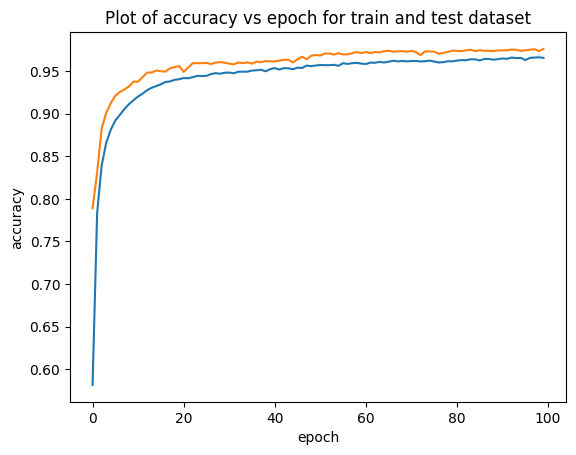

In [ ]:
import matplotlib.pyplot as plt
# Plot of accuracy vs epoch for train and test dataset
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Plot of accuracy vs epoch for train and test dataset")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

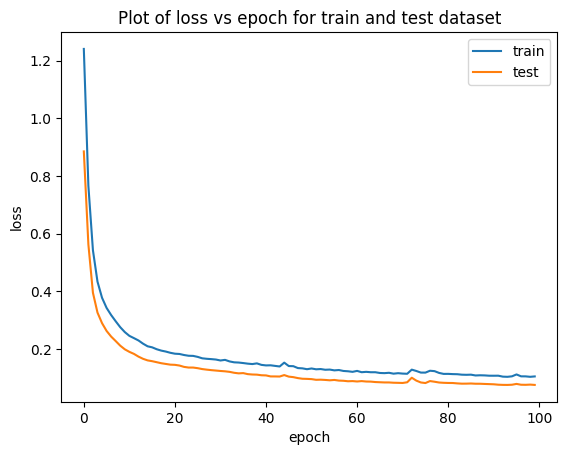

In [ ]:
# Plot of loss vs epoch for train and test dataset
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Plot of loss vs epoch for train and test dataset")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
# For Plot curve
y_pred_evaluation_test = to_categorical(np.argmax(y_pred_test, axis=1), 5)

In [ ]:
# Calculating Area under the curve
def AUC(actual_class, pred_class, average = "micro"):

    #Making a set of all the unique classes
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:

        #Making a list of all the classes except the current class
        other_class = [x for x in unique_class if x != per_class]

        #Making the current class with label 1 and all other classes as a label 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        # Calculating the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

In [ ]:
def plot_roc_curve(y_test,y_pred, classes):
    n_classes=len(classes)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    lw=2
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
    plt.figure(figsize=(10, 10))
    plt.plot(fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,)

    plt.plot(fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
           fpr[i],
           tpr[i],
           color=color,
           lw=lw,
        label="ROC curve of {0} (area = {1:0.2f})".format(classes[i], roc_auc[i]),
    )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("AUC")
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
import itertools
from itertools import cycle

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Prints and plots the confusion matrix.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# predicting target attribute on testing dataset
test_results = model.evaluate(X_test, y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

929/929 [==============================] - 3s 3ms/step - loss: 0.0737 - accuracy: 0.9763
Test results - Loss: 0.07372119277715683 - Accuracy: 97.62658476829529%


In [ ]:
print('AUC Score is on Test : ' , AUC(y_test_argmax, y_pred_argmax_test))

AUC Score is on Test :  {0: 0.9942011092455391, 1: 0.9760633552586432, 2: 0.8249966460398114, 3: 0.5999831530711951, 4: 0.9783661657682644}


Confusion matrix, without normalization


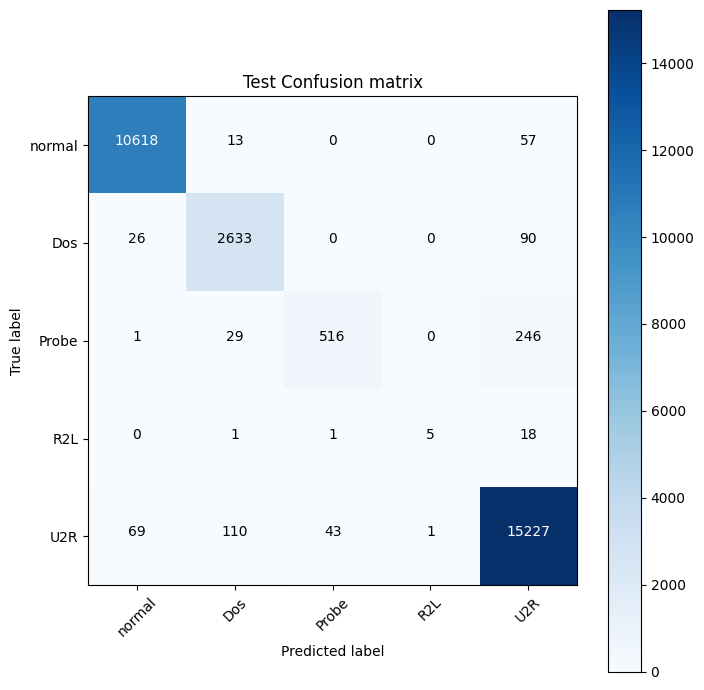

In [ ]:
# Compute confusion matrix
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test_argmax, y_pred_argmax_test)

# Plot non-normalized confusion matrix
plt.figure(figsize=(7, 7))
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Test Confusion matrix')
plt.show()

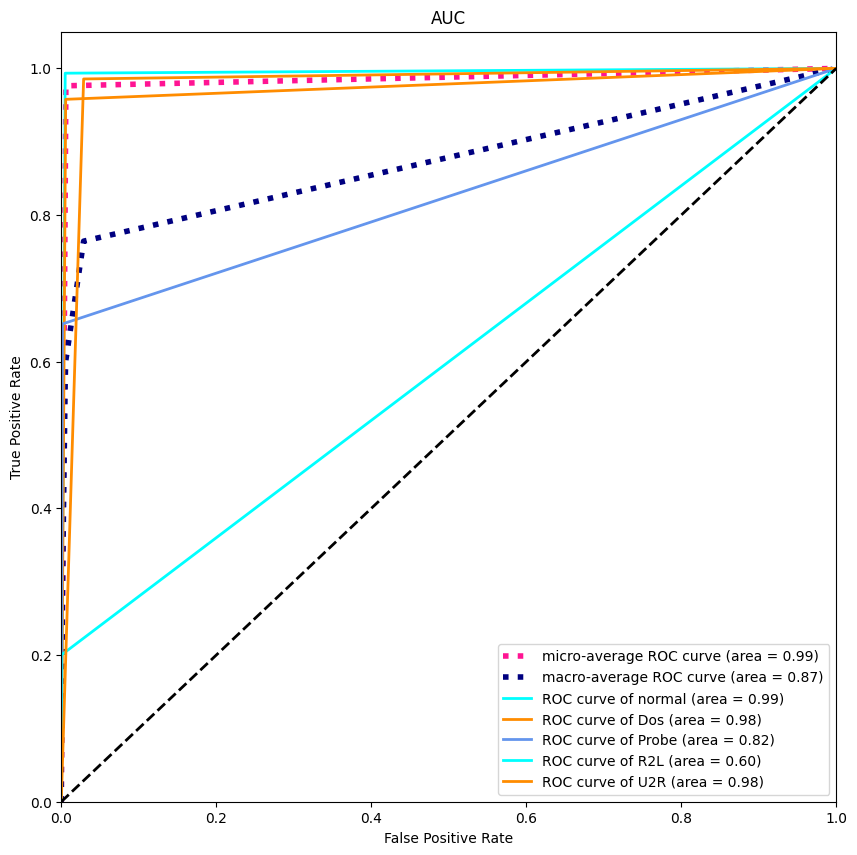

In [ ]:
plot_roc_curve(y_test,y_pred_evaluation_test,classes=classes)